# References

This notebook contains analysis of certificate references in Common Criteria certificates.

The notebook has two parts, an analysis part and a network visualization part.
But first some common initialization and data loading.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sec_certs.dataset.common_criteria import CCDataset
import pandas as pd
import seaborn as sns
import numpy as np
from pysankey import sankey

%matplotlib inline
plt.style.use("seaborn-whitegrid")
sns.set_palette("deep")
sns.set_context("notebook")  # Set to "paper" for use in paper :)

plt.rcParams['figure.figsize'] = (10, 6)

# Initialize
dset = CCDataset.from_web_latest()
df = dset.to_pandas()

## Reference analysis


### Count numbers of reference-rich certificates

- From the numbers follows that whenever a certificate is directly referencing some else, it also indirectly references some else
- We have more outgoing references than ingoing references, which kinda makes sense. You don't have to be aware that some other cert references you

In [2]:
df["has_outgoing_direct_references"] = df.directly_referencing.notnull()
df["has_incoming_direct_references"] = df.directly_referenced_by.notnull()
df["has_outgoing_indirect_references"] = df.indirectly_referencing.notnull()
df["has_incoming_indirect_references"] = df.indirectly_referenced_by.notnull()

df.loc[:, ["directly_referenced_by", "indirectly_referenced_by", "directly_referencing", "indirectly_referencing"]].notnull().describe()
# df.loc[(df.directly_referencing.notnull() & df.indirectly_referencing.isnull())]  # this results in an empty dataframe, see comment above

,directly_referenced_by,indirectly_referenced_by,directly_referencing,indirectly_referencing
count,5112,5112,5112,5112
unique,2,2,2,2
top,False,False,False,False
freq,4424,4424,3875,3875


### Plot direct references per category

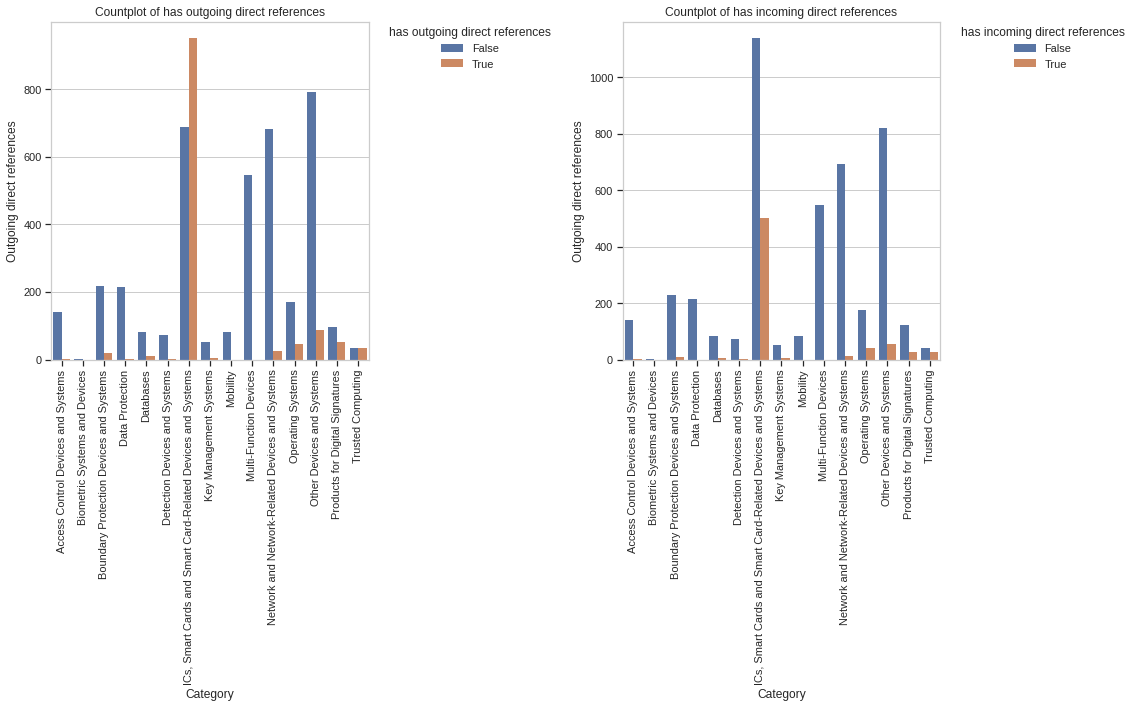

In [3]:
figure, axes = plt.subplots(1, 2)
figure.set_size_inches(16, 10)
figure.set_tight_layout(True)

col_to_depict = ["has_outgoing_direct_references", "has_incoming_direct_references"]

for index, col in enumerate(col_to_depict):
    countplot = sns.countplot(data=df, x="category", hue=col, ax=axes[index])
    countplot.set(
        xlabel="Category",
        ylabel="Outgoing direct references",
        title=f"Countplot of {' '.join(col.split('_'))}",
    )
    countplot.tick_params(axis="x", rotation=90)
    countplot.legend(title=' '.join(col.split('_')), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)


<AxesSubplot:>

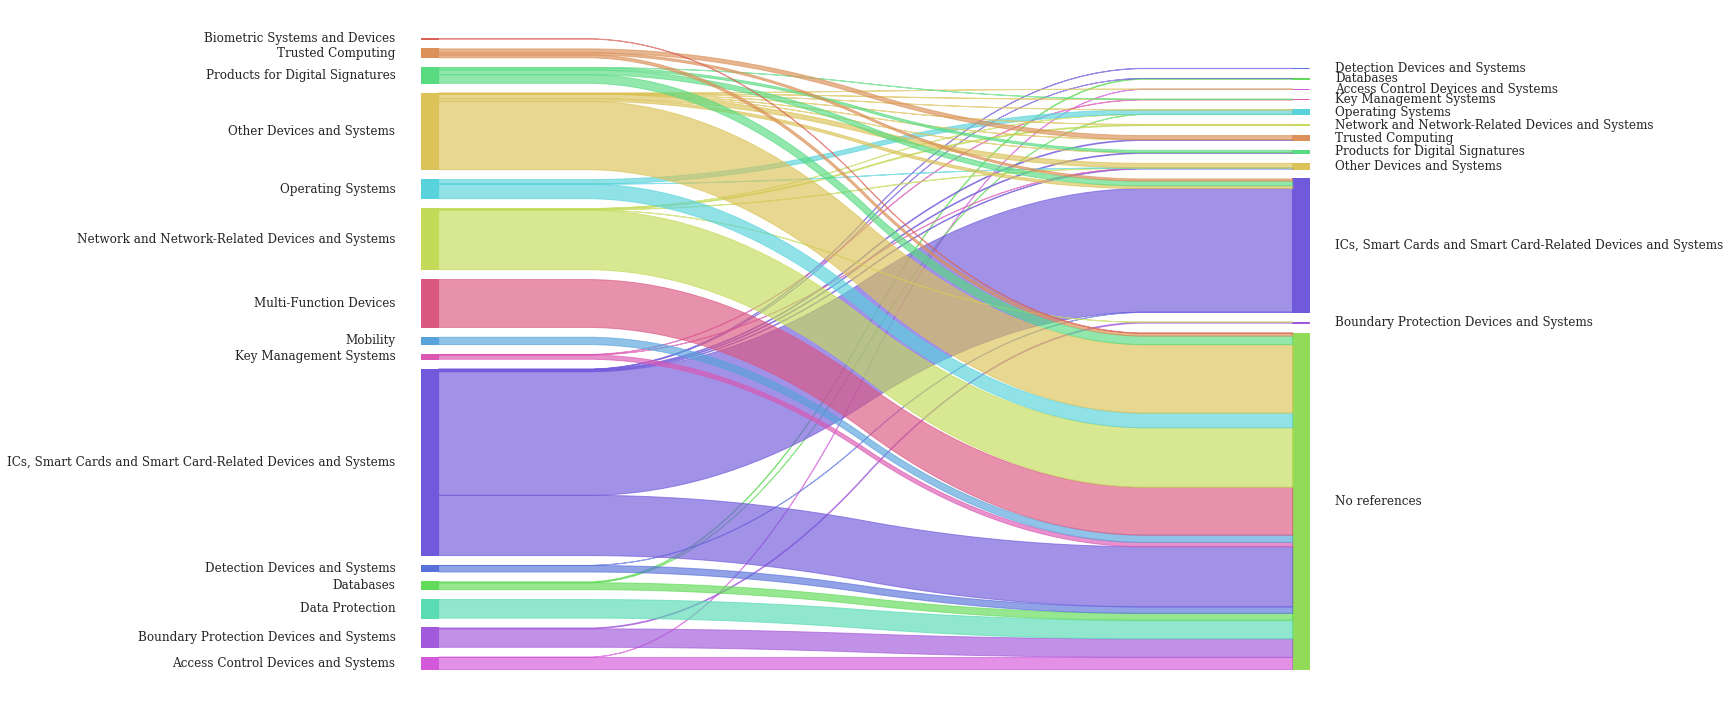

In [4]:
df_id_rich = df.loc[df.cert_id.notnull()]
cert_id_to_category_mapping = dict(zip(df.cert_id, df.category))

exploded = df_id_rich.loc[:, ["category", "directly_referencing"]].explode("directly_referencing")
cert_id_to_category_mapping[np.NaN] = "No references"

exploded["ref_category"] = exploded.directly_referencing.map(cert_id_to_category_mapping)
exploded = exploded.loc[exploded.ref_category.notnull()]

all_categories = set(exploded.category.unique()) | set(exploded.ref_category.unique())
colors = list(sns.color_palette("hls", len(all_categories), as_cmap=False).as_hex())
color_dict = dict(zip(all_categories, colors))

figure, axes = plt.subplots(1, 1)
figure.set_size_inches(24, 10)
figure.set_tight_layout(True)

sankey(exploded.category, exploded.ref_category, colorDict=color_dict, leftLabels=list(exploded.category.unique()), rightLabels=list(exploded.ref_category.unique()), fontsize=12, ax=axes)

### Plot direct references per scheme

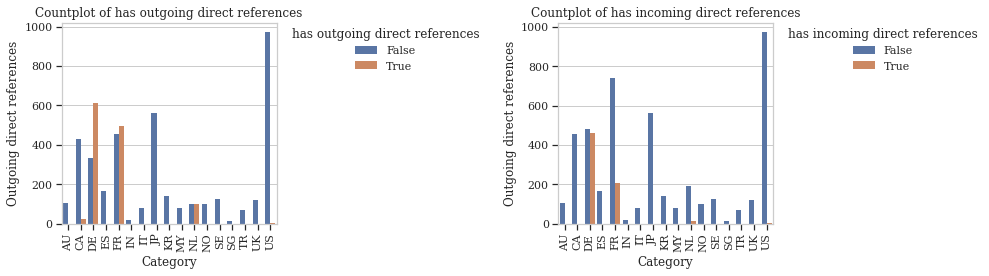

In [5]:
figure, axes = plt.subplots(1, 2)
figure.set_size_inches(14, 4)
figure.set_tight_layout(True)

col_to_depict = ["has_outgoing_direct_references", "has_incoming_direct_references"]

for index, col in enumerate(col_to_depict):
    countplot = sns.countplot(data=df, x="scheme", hue=col, ax=axes[index])
    countplot.set(
        xlabel="Category",
        ylabel="Outgoing direct references",
        title=f"Countplot of {' '.join(col.split('_'))}",
    )
    countplot.tick_params(axis="x", rotation=90)
    countplot.legend(title=' '.join(col.split('_')), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

### Number of certificates referencing archived certificates

Number of certificates that reference some archived certificate: 688


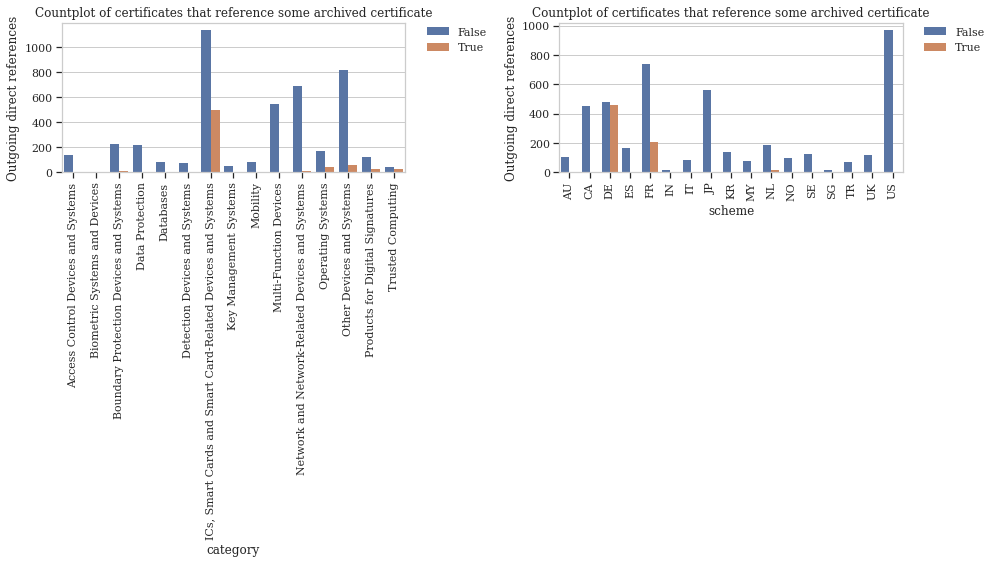

In [6]:
def references_archived_cert(references):
    if pd.isnull(references):
        return False

    return any([x in cert_ids] for x in references)

cert_ids = set(df.loc[((df.cert_id.notnull()) & (df.status == "archived")), "cert_id"].tolist())
df["references_archived_cert"] = df.directly_referenced_by.map(references_archived_cert)

print(f"Number of certificates that reference some archived certificate: {df.loc[df.references_archived_cert].shape[0]}")

col_to_depict = ["category", "scheme"]

figure, axes = plt.subplots(1, 2)
figure.set_size_inches(14, 8)
figure.set_tight_layout(True)

for index, col in enumerate(col_to_depict):
    countplot = sns.countplot(data=df, x=col, hue="references_archived_cert", ax=axes[index])
    countplot.set(
        xlabel=col,
        ylabel="Outgoing direct references",
        title="Countplot of certificates that reference some archived certificate",
    )
    countplot.tick_params(axis="x", rotation=90)
    countplot.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

### Count scheme references

A certificate is cross-referenced if there exists a bidirectional reference with any of the certificate that it directly references

<AxesSubplot:>

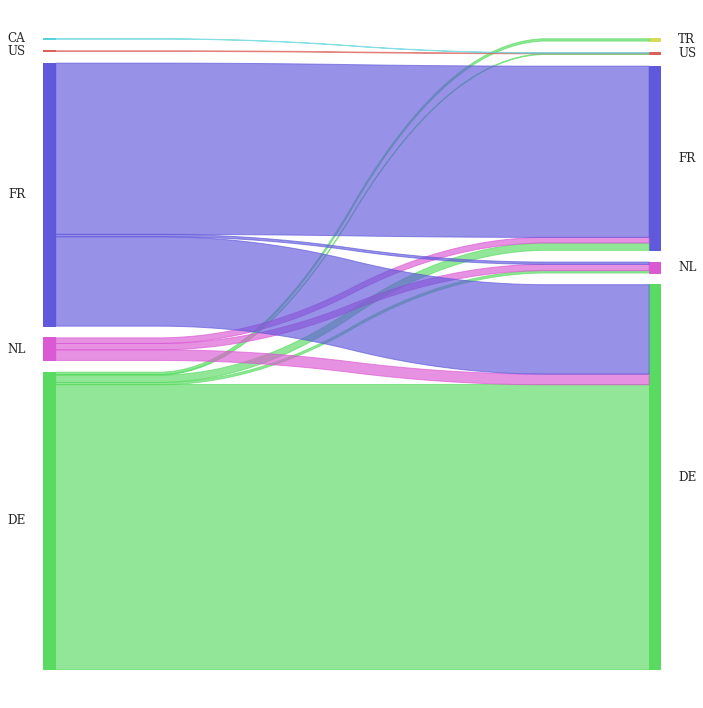

In [7]:
df_id_rich = df.loc[df.cert_id.notnull()]
cert_id_to_scheme_mapping = dict(zip(df.cert_id, df.scheme))

df_ref_rich = df_id_rich.loc[df.directly_referencing.notnull()]
exploded = df_ref_rich.loc[:, ["scheme", "directly_referencing"]].explode("directly_referencing")

exploded["ref_scheme"] = exploded.directly_referencing.map(cert_id_to_scheme_mapping)
exploded = exploded.loc[exploded.ref_scheme.notnull()]

all_schemes = set(exploded.scheme.unique()) | set(exploded.ref_scheme.unique())
colors = list(sns.color_palette("hls", len(all_schemes), as_cmap=False).as_hex())
color_dict = dict(zip(all_schemes, colors))

figure, axes = plt.subplots(1, 1)
figure.set_size_inches(10, 10)
figure.set_tight_layout(True)

sankey(exploded.scheme, exploded.ref_scheme, colorDict=color_dict, leftLabels=list(exploded.scheme.unique()), rightLabels=list(exploded.ref_scheme.unique()), fontsize=12, ax=axes)

### Temporal evolution of references

Shows plot with relative number of certificates for a given year that reference some other certificate

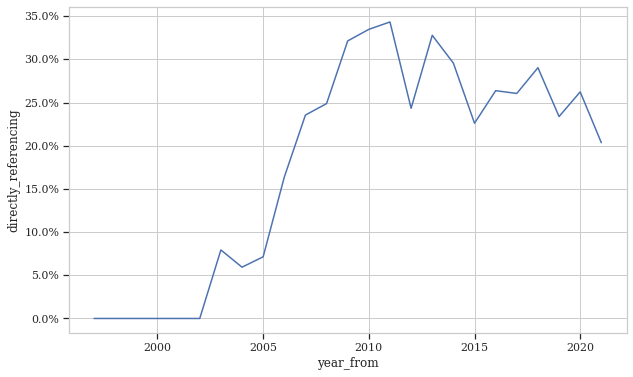

In [8]:
df_temporal = df.loc[df.year_from < 2022].groupby(["year_from"])["directly_referencing"].count().reset_index().set_index("year_from")
n_issued_certs = df.groupby("year_from").name.count().reset_index().rename(columns={"name": "n_certs"}).set_index("year_from")
df_temporal.directly_referencing = 100 * df_temporal.directly_referencing / n_issued_certs.n_certs

line = sns.lineplot(data=df_temporal, x="year_from", y="directly_referencing")
line.yaxis.set_major_formatter(mtick.PercentFormatter())

### Cross references

In [9]:
# Plotting w.r.t. scheme and category (both are interesting)

## Reference network visualization

In [10]:
certs_with_ids = {cert.heuristics.cert_id: cert for cert in dset if cert.heuristics.cert_id}

print(f"Certificates in dataset: {len(dset)}")
print(f"Certificates with extracted IDs: {len(certs_with_ids)}")

Certificates in dataset: 5112
Certificates with extracted IDs: 4902


### Certificate report references

In [11]:
refs_cr = nx.DiGraph()
for cert_id, cert in certs_with_ids.items():
    refs_cr.add_node(cert_id, cert=cert)
for cert_id, cert in certs_with_ids.items():
    if cr_refs := cert.heuristics.report_references.directly_referencing:
        for ref_id in cr_refs:
            refs_cr.add_edge(cert_id, ref_id, type=("cr",))
print(f"References in certificate reports: {len(refs_cr.edges)}")

References in certificate reports: 2157


### Security target references

In [ ]:
refs_st = nx.DiGraph()
for cert_id, cert in certs_with_ids.items():
    refs_st.add_node(cert_id, cert=cert)
for cert_id, cert in certs_with_ids.items():
    if st_refs := cert.heuristics.st_references.directly_referencing:
        for ref_id in st_refs:
            refs_st.add_edge(cert_id, ref_id, type=("st",))
print(f"References in security targets: {len(refs_st.edges)}")

### Combined references

In [ ]:
refs = nx.DiGraph()
refs.add_nodes_from(refs_cr)
refs.add_nodes_from(refs_st)
refs.add_edges_from(refs_cr.edges.data())
for edge in refs_st.edges:
    if edge in refs.edges:
        refs.edges[edge]["type"] = ("cr", "st")
    else:
        refs.add_edge(edge, *refs_st.edges[edge])
print(f"Combined references (not double counted): {len(refs.edges)}")

### Certificate overview
Enter the certificate you are interested in below and see its reference graph component.

In [ ]:
cert_id = "ANSSI-CC-2019/02"

In [ ]:
cert = certs_with_ids.get(cert_id)
if cert is None:
    print(f"Certificate with id {cert_id} is not present in the dataset.")

for component in nx.weakly_connected_components(refs):
    if cert_id in component:
        break

view = nx.subgraph_view(refs, lambda node: node in component)
print(f"Certificate with id {cert_id}:")
print(f" - is in a component with {len(view.nodes)} certificates and {len(view.edges)} references.")
print(f" - references {list(view[cert_id].keys())}")
print(f" - is referenced by {list(view.predecessors(cert_id))}")
print(f" - its page is at https://seccerts.org/cc/{cert.dgst}/")

In [ ]:
nx.draw(view, pos=nx.planar_layout(view), with_labels=True)